In [14]:
from dask.distributed import Client
client = Client('tcp://localhost:8786')
# client = Client()

In [15]:
import time
class Timed():
    def __init__(self):
        self.timedResume = {}
        self.functs = []
    def timed(self, func):
        functionName = func.__name__
        if functionName in self.functs:
            functionName += '_' + str(len(self.functs))
        self.timedResume[functionName] = []
        def f(*args, **kwargs):
            before = time.time_ns()
            rv = func(*args, **kwargs)
            after = time.time_ns()
            elapsed = after - before
            if elapsed:
                self.timedResume[functionName].append(elapsed)
            return rv
        return f
    def clearTimes(self):
        self.timedResume = dict( (k, []) for k in self.functs )
    def statisticSummary(self):
        records = []
        for k, v in self.timedResume.items():
            for i in v:
                records.append({'func': k, 'time': i})
        df = pd.DataFrame(records)
        if len(records) == 0:
            return df
        return df.groupby('func')
tm = Timed()
timed = tm.timed

In [16]:
class Example:
    __slots__ = ['label', 'item', 'timestamp', 'tries']
    def __init__(self, item, label=None):
        self.label = label
        self.item = item
        self.timestamp = time.time_ns()
        self.tries = 0
    def asDict(self):
        return {'label': self.label, 'item': self.item, 'timestamp': self.timestamp, 'tries': self.tries, }
    def __repr__(self):
        return 'Example({!r})'.format(self.asDict())
    def __str__(self):
        return repr(self)
    def __len__(self):
        return len(self.item)
t = Example(item=[])
print(t, type(t))
del t

Example({'label': None, 'item': [], 'timestamp': 1557260731828359141, 'tries': 0}) <class '__main__.Example'>


In [17]:
import scipy
class Cluster:
    __slots__ = [ 'label', 'center', 'n', 'lastExapleTMS', 'maxDistance', ]
    def __init__(self, label, center):
        self.label = label
        self.center = center
        self.n = 0
        self.maxDistance = 0.0
        self.lastExapleTMS = 0
    def asDict(self):
        return {'label': self.label, 'center': self.center, 'n': self.n, 
                'maxDistance': '{:2.2f}'.format(self.maxDistance), 'lastExapleTMS': self.lastExapleTMS,}
    def __repr__(self):
        return 'Cluster({!r})'.format(self.asDict())
    def radius(self):
        return self.maxDistance
    def dist(self, vec):
        return scipy.spatial.distance.euclidean(self.center, vec)
    def __add__(self, other):
        if type(other) == Example:
            self.n += 1
            self.lastExapleTMS = max(other.timestamp, self.lastExapleTMS)
            self.maxDistance = max(self.dist(other.item), self.maxDistance)
t = Cluster(label='label', center=[])
print(t, type(t))
del t

Cluster({'label': 'label', 'center': [], 'n': 0, 'maxDistance': '0.00', 'lastExapleTMS': 0}) <class '__main__.Cluster'>


In [27]:
import os, yaml
from sklearn.externals import joblib
from dask import delayed
import pandas as pd
from sklearn.cluster import KMeans

class MinasConsts:
    __slots__ = ['k', 'radiusFactor', 'noveltyThr', 'windowTimeSize', 'ndProcedureThr', 'representationThr', ]
    def __init__(self):
        self.k = 100
        self.radiusFactor = 1.1
        self.noveltyThr = 100
        self.windowTimeSize = 100
        self.ndProcedureThr = 2000
        self.representationThr = 3
CONSTS = MinasConsts()


@timed
def closestCluster(item, clusters):
    assert len(clusters) > 0
    assert len(item) > 0
    dist, nearCl = min( ((cl.dist(item), cl) for cl in clusters), key=lambda x: x[0])
    return dist, nearCl
@timed
def clustering(examples, label=None):
    kmeans = KMeans( n_clusters = min(CONSTS.k, int(len(examples) / (3 * CONSTS.representationThr))) )
    with joblib.parallel_backend('dask'):
        kmeans.fit(examples)
    return [Cluster(center=centroid, label=label) for centroid in kmeans.cluster_centers_]
@timed
def trainGroup(label, group):
    clusters = clustering(group, label)
    for ex in group:
        dist, nearCl = closestCluster(ex, clusters)
        nearCl += Example(ex)
    return [cluster for cluster in clusters if cluster.n > CONSTS.representationThr]


class Minas:
    __slots__ = ['exampleCount', 'knownCount', 'noveltyIndex',
                 'lastExapleTMS', 'lastCleaningCycle', 
                 'clusters', 'sleepClusters', 'unknownBuffer', ]
    def __init__(self):
        self.exampleCount = 0
        self.knownCount = 0
        self.noveltyIndex = 0
        self.lastExapleTMS = 0
        self.lastCleaningCycle = 0
        self.clusters = []
        self.sleepClusters = []
        self.unknownBuffer = []
    def asDict(self):
        asDictMap = lambda l: [x.asDict for x in l]
        return {
            'exampleCount': self.exampleCount, 'knownCount': self.knownCount, 'diff': self.exampleCount - self.knownCount,
            'noveltyIndex': self.noveltyIndex,
            'lastExapleTMS': self.lastExapleTMS, 'lastCleaningCycle': self.lastCleaningCycle,
            'clusters': asDictMap(self.clusters), 'sleepClusters': asDictMap(self.sleepClusters),
            'unknownBuffer': asDictMap(self.unknownBuffer),}
    def __repr__(self):
        return 'Minas({!r})'.format(self.asDict())
    def storeToFile(self, filename: str):
        directory = os.path.dirname(filename)
        if len(directory) > 0 and not os.path.exists(directory):
            os.makedirs(directory)
        with open(filename, 'w') as f:
            f.write(yaml.dump(self.asDict()))
        return self
    def restoreFromFile(self, filename: str):
        with open(filename, 'r') as f:
            dic = yaml.load(f, Loader=yaml.SafeLoader)
            self.exampleCount = dic.get('exampleCount', self.exampleCount)
            self.knownCount = dic.get('knownCount', self.knownCount)
            self.noveltyIndex = dic.get('noveltyIndex', self.noveltyIndex)
            self.lastExapleTMS = dic.get('lastExapleTMS', self.lastExapleTMS)
            self.lastCleaningCycle = dic.get('lastCleaningCycle', self.lastCleaningCycle)
            if 'clusters' in dic.keys():
                self.clusters = [Cluster(**cl) for cl in dic['clusters']]
            if 'sleepClusters' in dic.keys():
                self.sleepClusters = [Cluster(**cl) for cl in dic['sleepClusters']]
            if 'unknownBuffer' in dic.keys():
                self.unknownBuffer = [Example(**ex) for ex in dic['unknownBuffer']]
        return self
    #
    #
    def closestCluster(self, x, clusters):
        return closestCluster(x, clusters)
    def training(self, examplesDf):
        clusters = []
        for label, group in examplesDf.groupby('label'):
            clusters += delayed(trainGroup)(label, pd.DataFrame(iter(group['item'])))
        return clusters
    @timed
    def offline(self, examplesDf):
        self.clusters.extend(self.training().compute())
    #
    #
    @timed
    def classify(self, example, clusters=None):
        example.tries += 1
        if clusters == None:
            clusters = self.clusters + self.sleepClusters
        cluster, dist = self.closestCluster(example.item, clusters)
        isClassified = dist <= (CONSTS.radiusFactor * cluster.radius())
        return isClassified, cluster, dist, example
    def online(self, stream):
        for example in stream:
            if example is None:
                break
            self.onlineProcessExample(example) # custo 1000 -> 10
        return self
    @timed
    def onlineProcessExample(self, item):
        self.exampleCount += 1
        example = Example(item=item)
        self.lastExapleTMS = example.timestamp
        isClassified, cluster, dist, example = self.classify(example, self.clusters)
        if isClassified:
            example.label = cluster.label
            cluster.addExample(example)
            self.knownCount += 1
        else:
            self.unknownBuffer.append(example)
        # ------------------------------------------------------
        
        # ------------------------------------------------------
        if len(self.unknownBuffer) > CONSTS.ndProcedureThr:
            bufferFull(self.unknownBuffer)
            # evento buffer full
            self.unknownBuffer = []
            print('bufferFull')
            self.wakeupWithUnkownBuffer()
            self.noveltyDetection()
            self.cleanupCycle()
        return example, isClassified, cluster, dist
    @timed
    def wakeupWithUnkownBuffer(self):
        for sleepExample in self.unknownBuffer:
            isClassified, cluster, dist, example = self.classify(example, self.sleepClusters)
            if isClassified:
                sleepExample.label = cluster.label
                cluster.addExample(sleepExample)
                self.unknownBuffer.remove(sleepExample)
                # wakeup
                print('wakeup')
                self.clusters.append(cluster)
                self.sleepClusters.remove(cluster)
                self.counter += 1
    @timed
    def cleanupCycle(self):
        # Model ← move-sleepMem(Model, SleepMem, CurrentTime, windowSize)
        ogLen = len(self.clusters)
        newClusters = []
        for cl in self.clusters:
            if cl.lastExapleTMS < self.lastCleaningCycle:
                self.sleepClusters.append(cl)
            else:
                newClusters.append(cl)
        self.clusters = newClusters
        self.lastCleaningCycle = time.time_ns()
        print(f'put to sleep {ogLen - len(newClusters)} clusters')
        # ShortMem ← remove-oldExamples(ShortMem, windowsize)
        ogLen = len(self.unknownBuffer)
        self.unknownBuffer = [ex for ex in self.unknownBuffer if ex.tries >= 3]
        print(f'removed {ogLen - len(self.unknownBuffer)} examples')
    @timed
    def noveltyDetection(self):
        for cluster in clustering(self.unknownBuffer):
            # ---------------------------------------------------------------------------------------------------
            isRepresentative = cluster.n > CONSTS.representationThr
            # 
            near, dist = self.closestCluster(cluster.center, self.clusters + self.sleepClusters)
            distances = []
            for ex in unknownBuffer:
                d = cluster.dist(ex.item)
                if d <= (CONSTS.radiusFactor * cluster.radius()):
                    distances.append(d)
            mean = sum(distances) / len(distances)
            devianceSqrSum = sum((d - mean) **2 for d in distances)
            var = devianceSqrSum / len(distances)
            stdDevDistance = var **0.5
            silhouette = lambda a, b: (b - a) / max([a, b])
            # 
            isCohesive = silhouette(dist, stdDevDistance) > 0
            validationCriterion = isRepresentative and isCohesive
            # ---------------------------------------------------------------------------------------------------
            if not validationCriterion:
                continue
            if dist <= CONSTS.noveltyThr:
                print('Extention {}'.format(near.label))
                cluster.label = near.label
            else:
                self.noveltyIndex += 1
                label = 'Novelty {}'.format(self.noveltyIndex)
                print(label)
                cluster.label = label
            self.clusters.append(cluster)
        
t = Minas()
t.storeToFile('t.yaml')
t.restoreFromFile('t.yaml')
print(t, type(t))
del t

Minas({'exampleCount': 0, 'knownCount': 0, 'diff': 0, 'noveltyIndex': 0, 'lastExapleTMS': 0, 'lastCleaningCycle': 0, 'clusters': [], 'sleepClusters': [], 'unknownBuffer': []}) <class '__main__.Minas'>


In [28]:
from sklearn.datasets import fetch_covtype
dataset = fetch_covtype()

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)
total = len(dataset.data)
print('sizeof dataset', sizeof_fmt(dataset.data.nbytes), 'len', total)
print('dataset', dataset.data[0], dataset.target[0])

print('\nonPercentDataFrame setup')
onePercent = int(total*0.01)
%time onPercentDataFrame = pd.DataFrame(map(lambda x: {'item': x[0], 'label': x[1]}, zip(dataset.data[:onePercent], dataset.target[:onePercent])))

print('\ntenPercentDataFrame setup')
tenPercent = int(total*0.10)
%time tenPercentDataFrame = pd.DataFrame(map(lambda x: {'item': x[0], 'label': x[1]}, zip(dataset.data[:tenPercent], dataset.target[:tenPercent])))

fivePercent = int(total*0.05)
fivePercentDataIterator = zip(dataset.data[onePercent+1:fivePercent], dataset.target[onePercent+1:fivePercent])
allDataIterator = zip(dataset.data, dataset.target)

sizeof dataset 239.4MiB len 581012
dataset [2.596e+03 5.100e+01 3.000e+00 2.580e+02 0.000e+00 5.100e+02 2.210e+02
 2.320e+02 1.480e+02 6.279e+03 1.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00] 5

onPercentDataFrame setup
CPU times: user 11.3 ms, sys: 321 µs, total: 11.6 ms
Wall time: 11.4 ms

tenPercentDataFrame setup
CPU times: user 100 ms, sys: 3.45 ms, total: 104 ms
Wall time: 104 ms



model.offline(onPercentDataFrame)
CPU times: user 107 ms, sys: 3.9 ms, total: 111 ms
Wall time: 109 ms


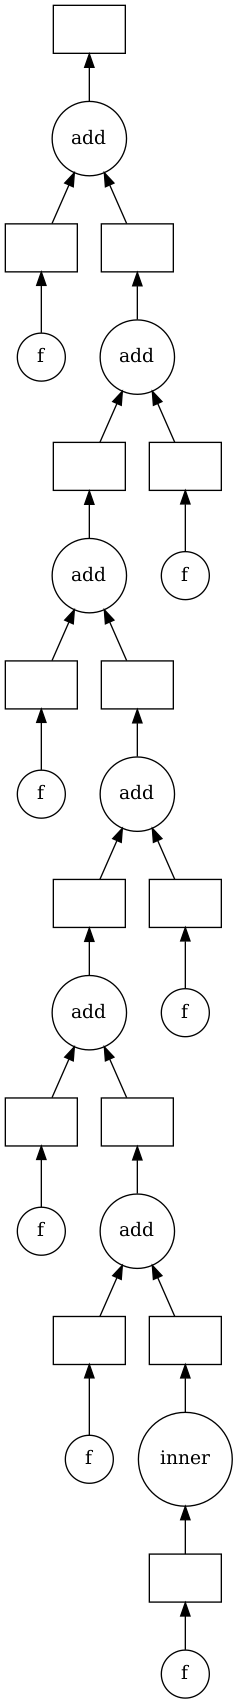

In [29]:
model = Minas()
print('\nmodel.offline(onPercentDataFrame)')
%time clusters = model.training(onPercentDataFrame)
clusters.visualize()

In [30]:
print('\n model.offline(onPercentDataFrame).compute()')
%time result = clusters.compute()
print('cluster count:', len(result))
print('\nstatisticSummary\n', tm.statisticSummary())
i, pos, neg, unk = 0, 0, 0, 0
for x, target in fivePercentDataIterator:
    example, isClassified, cluster, dist = model.onlineProcessExample(x)
    i += 1
    if not isClassified:
        unk += 1
        continue
    if example.label == traget:
        pos += 1
    else:
        neg += 1
print(f'pos {pos}({int(1000 * pos / i)}‰), neg {neg}({int(1000 * neg / i)}‰), unk {unk}({int(1000 * unk / i)}‰)')
tm.statisticSummary().describe()


 model.offline(onPercentDataFrame).compute()


TypeError: object of type 'int' has no len()

cluster count: 7

statisticSummary
 Empty DataFrame
Columns: []
Index: []


AssertionError: 

In [ ]:
def testRun(model, trainingSet, testSet):
    model.offline(trainingSet)
    pos, neg, unk = 0, 0, 0
    for x, target in testSet:
        example, isClassified, cluster, dist = model.onlineProcessExample(x)
        if not isClassified:
            unk += 1
            continue
        if example.label == traget:
            pos += 1
        else:
            neg += 1
    return model, tm.statisticSummary(), pos, neg, unk
#
model, statisticSummary, pos, neg, unk = testRun(Minas(), onPercentDataFrame, fivePercentDataIterator)

In [ ]:
class NoDealayed(Minas):
    @timed
    def NDoffline(self, examplesDf):
        @timed
        def NDclosestCluster(item, clusters):
            dist, nearCl = min( ((cl.dist(item), cl) for cl in clusters), key=lambda x: x[0])
            return dist, nearCl
        @timed
        def NDclustering(examples, label=None):
            kmeans = KMeans( n_clusters = min(CONSTS.k, int(len(examples) / (3 * CONSTS.representationThr))) )
            # with joblib.parallel_backend('dask'):
            kmeans.fit(examples)
            return [Cluster(center=centroid, label=label) for centroid in kmeans.cluster_centers_]
        @timed
        def NDtrainGroup(label, group):
            clusters = NDclustering(group, label)
            for ex in group:
                dist, nearCl = NDclosestCluster(ex, clusters)
                nearCl += Example(ex)
            return [cluster for cluster in clusters if cluster.n > CONSTS.representationThr]
        #
        clusters = []
        for label, group in df.groupby('label'):
            clusters += NDtrainGroup(label, pd.DataFrame(iter(group['item'])))
        self.clusters.extend(clusters)
        return clusters
#
modelND = NoDealayed()
print('\n modelND.NDoffline(onPercentDataFrame)')
%time clustersND = modelND.NDoffline(onPercentDataFrame)
print('cluster count:', len(clustersND))
print('\nstatisticSummary')
tm.statisticSummary().groupby('func').describe()

In [ ]:
help(min)